In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

%matplotlib inline

In [2]:
#Load mat file (from CSC file)
from scipy import io

mat = io.loadmat('A1_Post_Sleep.mat')

#Get data from mat file
LFP_Samples = mat['LFP_Samples']
LFP_TS = mat['LFP_Timestamps']
Fs = mat['Fs']
Fs = Fs.reshape(1)

#Change timestamps to start from 0
LFP_TS[0] = LFP_TS[0] - LFP_TS[0][0]

Text(0, 0.5, 'uV')

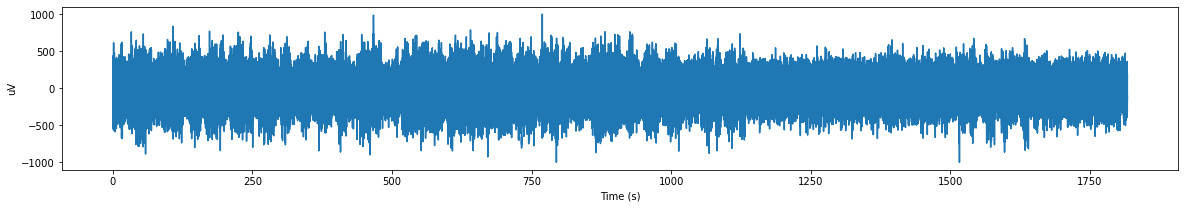

In [3]:
#Plot LFP
plt.figure(figsize=(20,3))
plt.plot(LFP_TS[0],LFP_Samples[0])
plt.xlabel('Time (s)')
plt.ylabel('uV')

In [4]:
#Normalize signal between 0 and 1
ab_max = np.max(abs(LFP_Samples[0]))
LFP_Samples = LFP_Samples / ab_max
LFP_Samples = LFP_Samples + 1
LFP_Samples /= 2

#Caps length of recording if true to save on memory
cap_rec = True
cap_length = 100 #In seconds (not samples)

if cap_rec:
    LFP_Samples = LFP_Samples[0][0:cap_length*Fs[0]]
    LFP_TS = LFP_TS[0][0:cap_length*Fs[0]]
    LFP_Samples = LFP_Samples.reshape(1,len(LFP_Samples))
    LFP_TS = LFP_TS.reshape(1,len(LFP_TS))

Text(0, 0.5, 'uV')

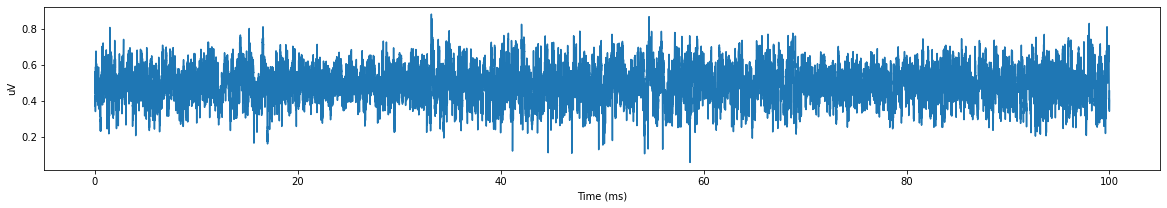

In [5]:
#Plot Resized LFP
plt.figure(figsize=(20,3))
plt.plot(LFP_TS[0],LFP_Samples[0])
plt.xlabel('Time (s)')
plt.ylabel('uV')

In [6]:
#Split data into 1st 2/3rds and last 3rd
seg = round(len(LFP_Samples[0])/3)
train_LFP = LFP_Samples[0][0:seg*2]
test_LFP = LFP_Samples[0][seg*2:]

In [7]:
def split_sequence(sequence, n_steps, la=1):
    '''
    Segment LFP into samples specified by size 'n_steps' with a single output sample
    
    la: Look-ahead - How may ms ahead the y value is (default = 1ms ie. next sample in sequence)
    '''
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        y_ix = i + n_steps + (la-1)
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if y_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[y_ix]
        
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [8]:
#Split training data into segments
n_steps = 300 #Size of each input sample
look_ahead = 10 #Predict y-value 10 ms in advance of sample sequence
X_train,y_train = split_sequence(train_LFP,n_steps,look_ahead)

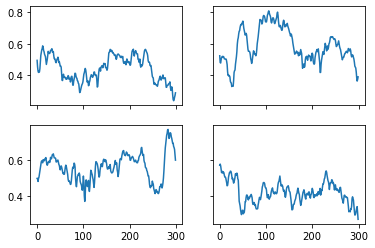

In [9]:
#Plot sample segments
rows, cols = 2, 2
fig, ax = plt.subplots(rows, cols,
                       sharex='col', 
                       sharey='row')
for row in range(2):
    for col in range(2):
        ax[row,col].plot(X_train[np.random.randint(0,len(X_train))])            

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras import optimizers
from tensorflow.keras.layers import LeakyReLU

# Reshape X_train into format for model
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))

# #Clip Optimizer to avoid NaN values
# optimizer = optimizers.Adam(learning_rate=0.01,clipvalue=0.5)

# --- Model architecture
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(50))
model.add(Dense(1))

#Compile model
model.compile(optimizer='adam', loss='mean_squared_error')


In [12]:
#Fit model
model.fit(X_train, y_train, epochs=5, verbose=1)

Train on 66357 samples
Epoch 1/5
66357/66357 [==============================] - 388s 6ms/sample - loss: 0.0058
Epoch 2/5
66357/66357 [==============================] - 377s 6ms/sample - loss: 0.0048
Epoch 3/5
66357/66357 [==============================] - 379s 6ms/sample - loss: 0.0047
Epoch 4/5
66357/66357 [==============================] - 382s 6ms/sample - loss: 0.0047
Epoch 5/5
66357/66357 [==============================] - 379s 6ms/sample - loss: 0.0047


In [13]:
#Split testing data into segments
n_steps = 300 #Size of each input sample
X_test,y_test = split_sequence(test_LFP,n_steps,look_ahead)

#Reshape testing data for model
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

#Make Predictions
predictions = model.predict(X_test)

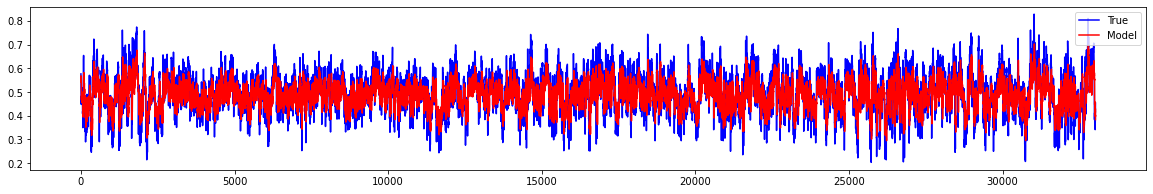

In [14]:
plt.figure(figsize=(20,3))
plt.plot(y_test,'b',label='True')
plt.plot(predictions,'r',label='Model')
plt.legend(loc='upper right')

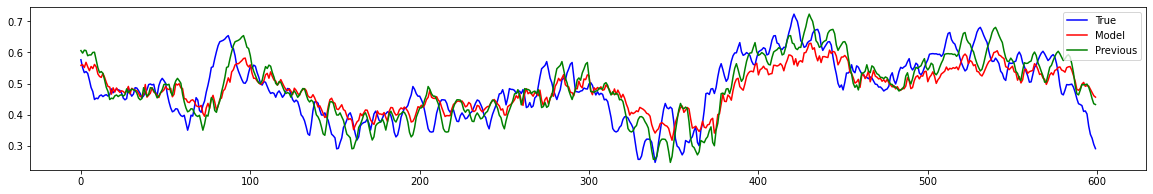

In [15]:
plt.figure(figsize=(20,3))
plt.plot(y_test[0:600],'b',label='True')
plt.plot(predictions[0:600],'r', label='Model')
plt.plot(test_LFP[300:900],'g', label='Previous')
plt.legend(loc="upper right")

Text(0, 0.5, 'Mean-Squared Error')

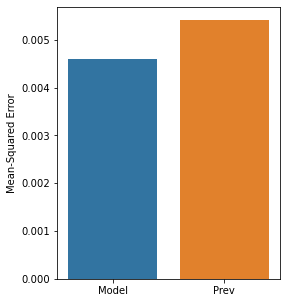

In [45]:
from sklearn.metrics import mean_squared_error

#Compare error to simply taking last value from 300ms time segment
model_error = mean_squared_error(y_test,predictions)
prev_error = mean_squared_error(y_test,test_LFP[300:300+len(y_test)])

plt.figure(figsize=(4,5))
sns.barplot(x=['Model','Prev'],y=[model_error,prev_error])
plt.ylabel('Mean-Squared Error')